# Beachwatch

This notebook examines the locatinos of the beachwatch stations. See the first notebook, ``0 Beachwatch Exploration`` for an overview of the dataset and how to open it. 

## Useful sites

* A great example of [mapping with geopandas](http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/).


In [1]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd

In [2]:
# Well just jump right into open the dataset. See  '0 Beachwatch Exploration' for details about
# opening packages. 
pkg = mp.open_package('http://library.metatab.org/ceden.waterboards.ca.gov-beachwatch-sandiego-2.zip')
df = pkg.resource('beachwatch-sd').read_csv(parse_dates=True)

# It looks like the prefix of the station code groups stations, maybe into watersheds. 
df['stationgroup'] = df.stationcode.str[:2]

# The results has a large range, so log transformation makes them easier to visualize.
df['log_result'] = df.result.apply(np.log10)

# Just focus on one type of analyte. 
dfs = df[(df.analyte == 'Coliform, Total') & (df.unit == 'MPN/100 mL')]
len(dfs)


47515

# Geographic Analysis

The Beachwatch data has position information for the stations, which we will need to match the stations to watersheds. Let's start by looking at their positions on a map. Shapely and Geopandas are the main tools for working with geographic data with Pandas and Jupyter. 


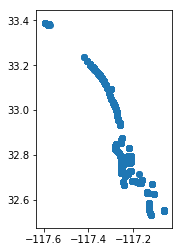

In [3]:

## Create a new GeoPandas frame, converting the targetlongitude and targetlatitude
## colums to a Shapely Point and assigning it to the frame's geometry

gdf = gpd.GeoDataFrame(dfs, geometry=
                        [Point(x,y) for x,y in zip(dfs.targetlongitude, dfs.targetlatitude)])

# Here is a quick plot
gdf.plot()

## Add a County Outline

The quick graph doesn't have any context for the rest of the county, so let's get another Metatab package with geographic information for the outline of San Diego county. 

In [4]:

## Load a Metapack data package of the US Counties, then extract San Diego county by it's FIPS code, state=6
## county=73 
counties_pkg = mp.open_package('http://library.metatab.org/census.gov-counties-2017-2.csv')

# Use the Metapack feature for turning the Pandas dataframe into a GeoPandas dataframe
counties = counties_pkg.resource('counties').geoframe()

sd_county = counties[(counties.statefp==6) & (counties.countyfp==73) ]

It will be important to verify that the groups of stations are actually geographically close, which is easy to check by coloring each of the groups. The Geopandas ``.plot()`` method has a ``column`` parameter which specifies the colum used to differentiate point colors. 

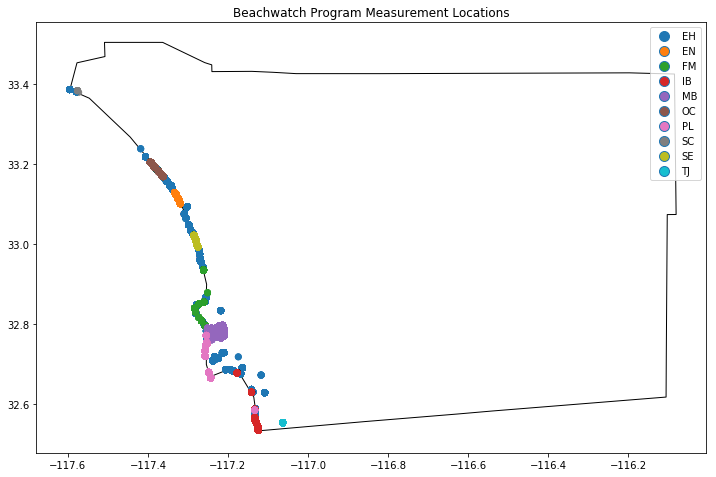

In [5]:
## Plot the county, then use the same Matplotlib axis to plot the points. 
base = sd_county.plot(color='white', edgecolor='black', figsize=(8*1.5,8))
gdf.plot(ax=base,  column='stationgroup', legend=True)
plt.title("Beachwatch Program Measurement Locations")
plt.show()

The 'EH' group seems really spread out, so let's have a closer look at just that group. 


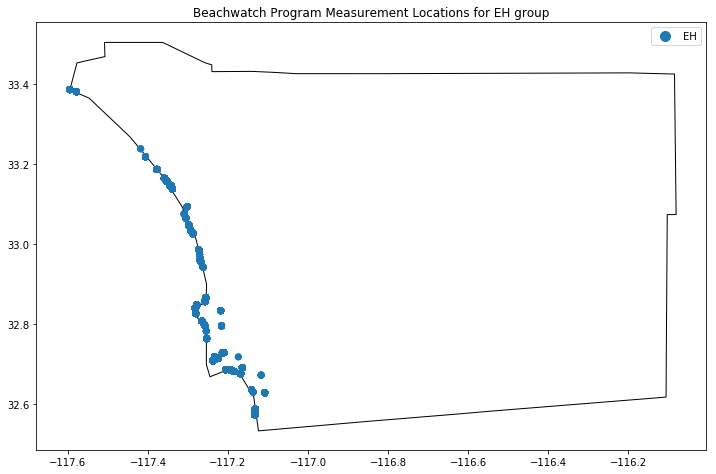

In [6]:
## Plot the county, then use the same Matplotlib axis to plot the points. 
base = sd_county.plot(color='white', edgecolor='black', figsize=(8*1.5,8))
gdf[(gdf.stationgroup == 'EH') ].plot(ax=base,  column='stationgroup', legend=True)
plt.title("Beachwatch Program Measurement Locations for EH group")
plt.show()

The 'EH' group is all over the coast, so the stations in that group probably wont correlate with each other very well, and there are a small number of records for each of the EH stations.  Let's exclude it. 


In [7]:
dfs = dfs[dfs.stationgroup != 'EH']


In [8]:
# Write the station positions so we can load them into a map. 
dfs[['stationgroup','stationcode','stationname','targetlongitude','targetlatitude']].drop_duplicates().to_csv('stations.csv')

There is a [higher detail map of stations in PDF format in the shared Google Drive](https://drive.google.com/file/d/1_QVzn1wylIjlQQgn3DO7fDX_qCUYc7jy/view?usp=sharing), also this image below. Both the PDF and the image below were created by exporting the positions of stations in CSV and loading them into QGIS. 



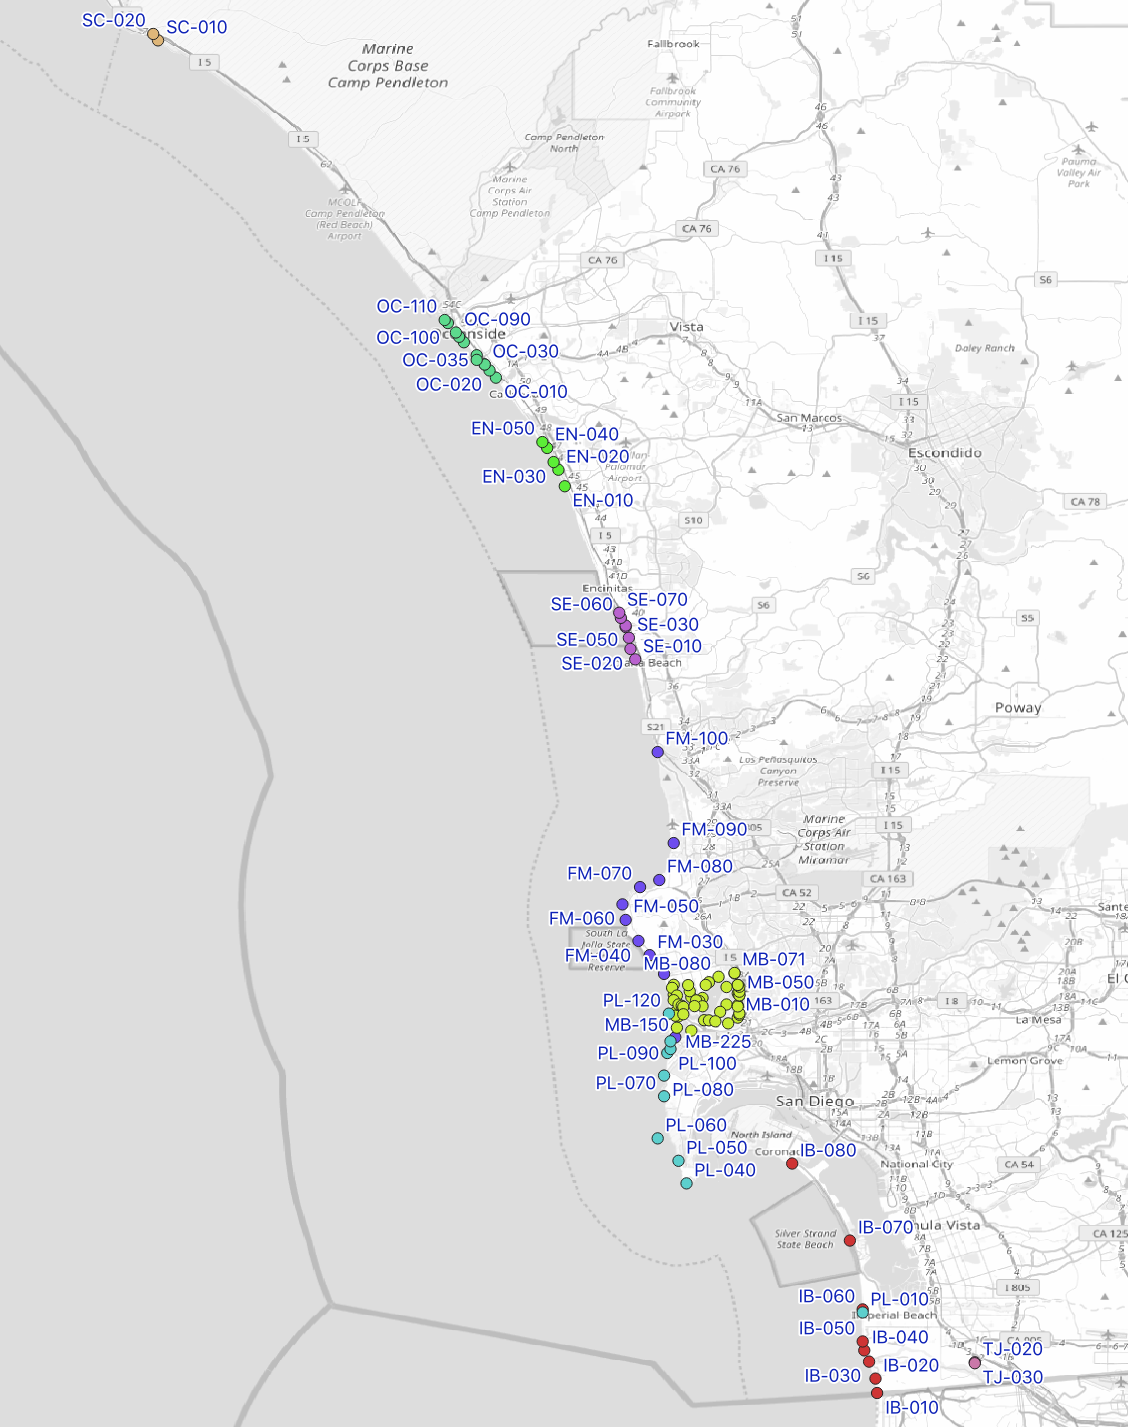

In [10]:

from IPython.display import Image
Image(filename='../assets/beachwatchmap.png') 